In [131]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random

In [132]:
def resize_image(image, target_size):

    original_height, original_width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    
    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * original_width / target_width)
            original_y = int(i * original_height / target_height)
            resized_image[i, j] = image[original_y, original_x]
    
    return resized_image

In [133]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (350, 350))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

data, filenames,label, path, distribusi = insertGambar("cars/")

Mahindra Scorpio


 32%|███▏      | 100/316 [00:07<00:15, 14.05it/s]


Rolls Royce


 32%|███▏      | 100/309 [00:06<00:13, 15.12it/s]


Swift


 24%|██▎       | 100/424 [00:06<00:20, 15.48it/s]


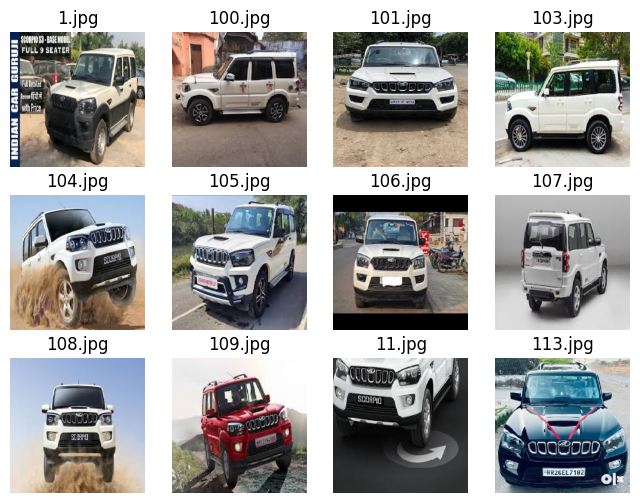

In [134]:
def display(gambar, title,rows,columns):
    fig = plt.figure(figsize=(2*columns, rows*2)) 
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1) 
        plt.imshow(gambar[i], cmap='gray')
        plt.axis('off') 
        plt.title(title[i])

display(data, filenames, 3, 4)

In [135]:
def findPixel(img,skala=256):
    pixel = np.zeros(skala)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel[int(img[i,j])] =  pixel[int(img[i,j])] + 1
    return pixel

def findProbability(img, pixel,skala=256):
    for i in range(skala):
        pixel[i] = pixel [i] / (img.shape[0] * img.shape[1])
    return pixel

def findCumulative(arr,skala=256):
    for i in range(skala):
        if i != 0:
            arr[i] = arr[i] + arr[i-1]
    return arr

def equalization(img):
    pixel = findPixel(img)
    pixel = findProbability(img,pixel)
    pixel = findCumulative(pixel)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i,j] = pixel[int(img[i,j])] * 255
    return img

def equalizationData(data):
    equalized_data = []
    for i in tqdm(range(len(data))):
        equalized_data.append(equalization(data[i]))
    return equalized_data

In [136]:
kernel = np.array([[0, 0, 1, 0, 0],
                   [0, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 0],
                   [0, 0, 1, 0, 0]])

def grayScaling(img):
    gaussKernel = np.ones((3,3))/9
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    filteredR = cv.filter2D(r,-1,gaussKernel)
    filteredG = cv.filter2D(g,-1,gaussKernel)
    filteredB = cv.filter2D(b,-1,gaussKernel)
    return np.round(filteredR/3 + filteredG/3 + filteredB/3).astype(np.uint8)

def grayScalingData(data):
    gray_data = []
    for i in tqdm(range(len(data))):
        gray_data.append(grayScaling(data[i]))
    return gray_data

def threshold(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < 128:
                image[i][j] = 0
            if image[i][j] >= 128:
                image[i][j] = 255
    return image

def minimum(matrix):
    min = matrix[0][0]
    for i in range (matrix.shape[0]):
        for j in range (matrix.shape[1]):
            if(matrix[i][j] < min):
                min = matrix[i][j]
    return min  

def maximum(matrix):
    max = matrix[0][0]
    for i in range (matrix.shape[0]):
        for j in range (matrix.shape[1]):
            if(matrix[i][j] > max):
                max = matrix[i][j]
    return max 

def dilation(image, kernel):
    row = ((kernel.shape[0]-1)//2)
    column = ((kernel.shape[1]-1)//2)
    result = np.zeros(image.shape)
    image2 = threshold(image)
    for i in range(row, image.shape[0]-row):
        for j in range(column, image.shape[1]-column):
            window = image2[i-row:i+row+1, j-column:j+column+1]
            product = window*kernel
            result[i,j]= maximum(product)
    return result

def erotion(image, kernel):
    row = ((kernel.shape[0]-1)//2)
    column = ((kernel.shape[1]-1)//2)
    result = np.zeros(image.shape)
    image2 = threshold(image)
    for i in range(row, image.shape[0]-row):
        for j in range(column, image.shape[1]-column):
            window = image2[i-row:i+row+1, j-column:j+column+1]
            product = window*kernel
            result[i,j]= minimum(product)
    return result

def closing(image, kernel):
    dilate = dilation(image, kernel)
    result = erotion(dilate, kernel)
    return result

def normalize_image(image, skala_min=0, skala_max=255):
    tinggi, lebar = image.shape
    hasil = np.zeros((tinggi, lebar))
    min_val = np.min(image)
    max_val = np.max(image)
    for i in range(tinggi):
        for j in range(lebar):
            hasil[i, j] = (image[i, j] - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min
    return hasil

def edge_detection(image, low_threshold=50, high_threshold=150):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    edges = cv.Canny(image, low_threshold, high_threshold)
    return edges

def remove_background(img):
    # Convert image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Thresholding to segment foreground (object) from background
    _, thresh = cv.threshold(gray, 100, 255, cv.THRESH_BINARY)
    
    # Apply morphological operations to clean up the thresholded image
    kernel = np.ones((5,5), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
    
    # Create a mask where white (255) pixels represent the object (foreground)
    mask = np.zeros_like(gray)
    mask[opening == 255] = 255
    
    # Apply the mask to the original image to remove the background
    masked_img = cv.bitwise_and(img, img, mask=mask)
    
    return masked_img

def apply_custom_kernel(image, kernel):
    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]
    kernel_radius = kernel_size // 2
    output = np.zeros_like(image)

    for y in range(image_height):
        for x in range(image_width):
            value = 0
            for ky in range(kernel_size):
                for kx in range(kernel_size):
                    img_y = y + ky - kernel_radius
                    img_x = x + kx - kernel_radius
                    if img_y >= 0 and img_y < image_height and img_x >= 0 and img_x < image_width:
                        value += image[img_y, img_x] * kernel[ky, kx]
            output[y, x] = np.clip(value, 0, 255)

    return output

def augment_image(image):
    """
    Augment a single image by randomly applying one of several transformations.
    
    Parameters:
    image (np.array): Input image to augment.
    
    Returns:
    np.array: Augmented image.
    """
    augmentations = [
        lambda x: cv.rotate(x, cv.ROTATE_180),                # Rotate 180 degrees
        lambda x: cv.flip(x, 1),                              # Flip horizontally
        lambda x: cv.flip(x, 0),                              # Flip vertically
        lambda x: cv.rotate(x, cv.ROTATE_90_COUNTERCLOCKWISE),# Rotate 90 degrees counterclockwise
        lambda x: cv.rotate(x, cv.ROTATE_90_CLOCKWISE),       # Rotate 90 degrees clockwise
    ]
    
    # Randomly choose an augmentation to apply
    augmentation = random.choice(augmentations)
    
    # Apply the chosen augmentation
    augmented_image = augmentation(image)
    
    return augmented_image

def noise_reduction(img):
    """
    Manually reduces noise in the image using Gaussian blur with a fixed kernel size.
    """
    kernel_size = 5
    sigma = 1.0

    # Generate Gaussian kernel manually
    kernel = [[0] * kernel_size for _ in range(kernel_size)]
    sum_kernel = 0
    for x in range(-kernel_size // 2, kernel_size // 2 + 1):
        for y in range(-kernel_size // 2, kernel_size // 2 + 1):
            value = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            kernel[x + kernel_size // 2][y + kernel_size // 2] = value
            sum_kernel += value

    # Normalize kernel
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i][j] /= sum_kernel

    # Apply Gaussian blur
    img_padded = cv.copyMakeBorder(img, kernel_size // 2, kernel_size // 2, kernel_size // 2, kernel_size // 2, cv.BORDER_CONSTANT, value=0)
    denoised_img = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            sum_value = 0
            for k in range(kernel_size):
                for l in range(kernel_size):
                    sum_value += kernel[k][l] * img_padded[i + k][j + l]
            denoised_img[i, j] = sum_value

    return denoised_img

def preprocessing(images):
    preproses = []
    # sharpen_kernel = np.array([[1/9, 1/9, 1/9],[1/9, 8/9, 1/9],[1/9, 1/9, 1/9]])
    for img in images:
        gray_img = grayScaling(img)
        # noise_red_img = noise_reduction(gray_img)
        equal = equalization(gray_img)
        normalize_img = normalize_image(equal)
        sharpened_image = apply_custom_kernel(normalize_img, np.array([[1/10, 1/10, 1/10],[1/10, 1/5, 1/10],[1/10, 1/10, 1/10]]))
        # edges = edge_detection(gray_img)
        # threshold_img = threshold(gray_img)
        # dilasi_img = dilation(threshold_img, kernel)
        # opening_img = erotion(dilasi_img, kernel)
        # for i in range(3):
        #     if(i == 0):
        #         augmented_img = sharpened_image
        #     else:
        #         augmented_img = augment_image(sharpened_image)
        #     preproses.append(augmented_img)
        preproses.append(sharpened_image)
    return preproses

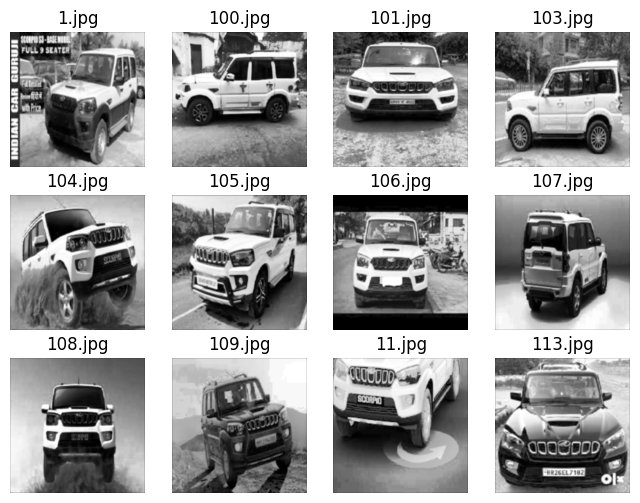

In [137]:
pro1 = preprocessing(data)
display(pro1, filenames, 3, 4)

In [138]:
def matriksTransformasi(matriks):
    return matriks.T

def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

def derajat(img, derajat):
    max_val = np.max(img)
    temp = np.zeros((int(max_val)+1, int(max_val)+1))
    if derajat == 0:
        for i in range(len(img)):
            for j in range(len(img[0])-1):
                idx1 = int(img[i,j])
                idx2 = int(img[i,j+1])
                temp[idx1, idx2] += 1
    elif derajat == 45:
        for i in range(len(img)-1):
            for j in range(len(img[0])-1):
                idx1 = int(img[i+1,j])
                idx2 = int(img[i,j+1])
                temp[idx1, idx2] += 1
    elif derajat == 90:
        for i in range(len(img)-1):
            for j in range(len(img[0])):
                idx1 = int(img[i+1,j])
                idx2 = int(img[i,j])
                temp[idx1, idx2] += 1
    elif derajat == 135:
        for i in range(len(img)-1):
            for j in range(len(img[0])-1):
                idx1 = int(img[i,j])
                idx2 = int(img[i+1,j+1])
                temp[idx1, idx2] += 1
    hasil = temp + matriksTransformasi(temp)
    total = sum(hasil)
    for i in range(len(hasil)):
        for j in range(len(hasil)):
            hasil[i,j] /= total
    return hasil



def ekstraksi(image):
    hasil = []
    for img in tqdm(image):
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil

In [139]:
ekstraksiData = ekstraksi(pro1)

100%|██████████| 300/300 [01:22<00:00,  3.65it/s]


In [140]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil

def correlation(data):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean_x += i * data[i][j]
            mean_y += j * data[i][j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std_x += (i - mean_x) ** 2 * data[i][j]
            std_y += (j - mean_y) ** 2 * data[i][j]
    std_x = math.sqrt(std_x)
    std_y = math.sqrt(std_y)
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean_x) * (j - mean_y) * data[i][j]
    hasil /= std_x * std_y
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

In [141]:
def ekstraksiFitur(data, path):
    hasil = []
    batas_gambar = len(data)
    for i in tqdm(range(batas_gambar)):
        extracted_data = [path[i]]
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
            asm_val = asm(data[i][j])
            extracted_data.append(asm_val)
            entropy_val = entropy(data[i][j])
            extracted_data.append(entropy_val)
        hasil.append(extracted_data)
    return hasil

In [142]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = ['path']
for fitur in fiturs:
    headers.extend([f'{fitur}_{angle}' for angle in angles])
headers.extend([f'asm_{angle}' for angle in angles])
headers.extend([f'entropy_{angle}' for angle in angles])

In [143]:
hasil = ekstraksiFitur(ekstraksiData, path)
df = pd.DataFrame(hasil, columns=headers)

100%|██████████| 300/300 [03:23<00:00,  1.47it/s]


In [144]:
df.to_csv('before.csv', index=False)

df = pd.read_csv('before.csv')

X = df.drop('path', axis=1)
y = df['path']



In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [148]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("K-Nearest Neighbors (KNN) Accuracy:", knn_accuracy)

svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Support Vector Machine (SVM) Accuracy:", svm_accuracy)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
# print("Random Forest Accuracy:", rf_accuracy)

K-Nearest Neighbors (KNN) Accuracy: 0.48333333333333334
Support Vector Machine (SVM) Accuracy: 0.65


In [149]:
models = {'KNN': knn_pred, 'SVM': svm_pred}
results = {}

for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[model_name] = [accuracy, precision, recall, f1]

results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T
print(results_df)

     Accuracy  Precision    Recall  F1-Score
KNN  0.483333   0.474386  0.483333  0.477132
SVM  0.650000   0.655000  0.650000  0.649206
